In this case study example, I have been tasked with the responsibility of exploring their database. They have shared a SQLite database with me containing this (fabricated) data. The file is named db1.sqlite3. In order to query the database, I use the command line client
(sqlite3) with Python.

In [1]:
import sqlite3
import pandas as pd
conn=sqlite3.connect("/Users/jiezhao/Downloads/db1.sqlite3")
c=conn.cursor

# Section I: Exploring the database
In this first exercise, I have been asked a few basic questions about the users of this platform  so that I can diagnose any issues I might have connecting to or working with the data.
For example, 
1. How many users have signed up?
    The answer is 64393.
2. How many users signed up prior to 2018-02-03 ?
    The answer is 35826.
3. What percentage of users have added pets?
    The answer is 80.43%.
4. Of those users,how many pets have they added on average?
    The answer is 1.501.
5. What percentage of pets play well with cats?
    The answer is 24.85%.

The following is the code for this exercise.

In [2]:
# 1.How many User have signed up
query = '''
  select
  count(*) as totalUsers from
    people_person;
'''
df = pd.read_sql_query(query, conn)
print(df)

# 2.How many User signed up prior to 2018-02-03
query = '''
  select
  count(*) as UserSignedup from
    people_person where date_joined <'2018-02-03';
'''
df1 = pd.read_sql_query(query, conn)
print(df1)

# What percentage of users have added pets?
query = '''
  select * from pets_pet;
'''
dfpet = pd.read_sql_query(query, conn)
#dfpet.head()
query = '''
  select
  round(count(DISTINCT owner_id)/64393.00 *100,2) as PercentagePetsAdded from
    pets_pet;
'''
dfpet = pd.read_sql_query(query, conn)
print(dfpet)

query = '''
  select
  round(count(id)/round(count(DISTINCT owner_id),2),3) as AveragePetPerOwner from
    pets_pet;
'''
dfpet2 = pd.read_sql_query(query, conn)
print(dfpet2)

query = '''
  select
  round(sum(plays_cats)/round(count(id),2)*100,2) as PertPlayWCat from
    pets_pet;
'''
dfpet2 = pd.read_sql_query(query, conn)
print(dfpet2)

   totalUsers
0       64393
   UserSignedup
0         35826
   PercentagePetsAdded
0                80.43
   AveragePetPerOwner
0               1.501
   PertPlayWCat
0         24.85


# Section II: Conversations and Bookings

They have two types customers: owner and provider. When an owner needs service, they can create a conversation with another user that offers the service they are interested in. After exchanging some messages and possibly meeting in person, that conversation hopefully books. Occasionally, some conversations that have booked may be cancelled. For uncancelled bookings, both owners and sitters have the option of leaving a review. They want to know whether the owner or provider more likely to leave a review and which tends to leave better reviews? 

Let’s dig in!

As a human being,visual information with text information usually can more easily convince yourself and make a assumption.



In [3]:
query = '''
   select c.id,s.reviewer_id,c.requester_id,sum((case when s.reviewer_id =c.requester_id then 1 else 0 end)) as owner_review,Sum((case when s.reviewer_id !=c.requester_id then 1 else 0 end)) as provider_review from
   (select id, requester_id from conversations_conversation  where booked_at!='NULL' and cancelled_at is NULL) c
   left join 
   conversations_review s on s.conversation_id =c.id
   group by c.id
'''
df2 = pd.read_sql_query(query, conn)
#df2  will give you a total number of rows ( number of reviews) is 30093;
#df2.sum() will give you a total number of owners who gave a reviews is 22499 and total number of provider who gave 
#          gave a review is 6062
#df2.sum()
df2.mean()

id                 40133.583425
reviewer_id        29894.929313
requester_id       38021.374040
owner_review           0.747649
provider_review        0.201442
dtype: float64

Above query will give you an answer:  There are total 30093 uncancelled bookings. Among these, 22499 bookings were  reviewed by users and only 6062 bookings were reviewed by provider. The percentage of users will give a review after books will be 74.76% and the percentate that provider will a review is abount 20.14%. From this information, we will give a rough guess, the users are more likely to leave a review.

In [4]:
# Let's find how many owners gave a review in each category:

query = '''
 
  select owner_review, count(owner_review) as owner_total from
  
 ( select c.id,s.reviewer_id,c.requester_id,stars,sum((case when s.reviewer_id =c.requester_id then stars else 0.0 end)) as owner_review,Sum((case when s.reviewer_id !=c.requester_id then stars else 0.0 end)) as provider_review from
   (select id, requester_id from conversations_conversation  where booked_at!='NULL' and cancelled_at is NULL) c
   left join 
   conversations_review s on s.conversation_id =c.id
   group by c.id ) E
 where owner_review!=0
 group by owner_review

   
'''
df4 = pd.read_sql_query(query, conn)
df4.head()

,owner_review,owner_total
0,1,1318
1,2,1302
2,3,1313
3,4,1339
4,5,17227


From this query, we can see that among 22499 users' reviews, there are total 1318+1302+1313+1339=5272 review are less than 5 stars and 17227 reviews are 5 stars. The 5 stars rate is 76.57%.

In [5]:
# Let's find how many provider gave a review in each category

query = '''
 
  select provider_review, count(provider_review) as provider_total from
  
 ( select c.id,s.reviewer_id,c.requester_id,stars,sum((case when s.reviewer_id =c.requester_id then stars else 0.0 end)) as owner_review,Sum((case when s.reviewer_id !=c.requester_id then stars else 0.0 end)) as provider_review from
   (select id, requester_id from conversations_conversation  where booked_at!='NULL' and cancelled_at is NULL) c
   left join 
   conversations_review s on s.conversation_id =c.id
   group by c.id ) E
 where provider_review!=0
 group by provider_review

   
'''
df5 = pd.read_sql_query(query, conn)
df5.head()

,provider_review,provider_total
0,1.0,679
1,2.0,644
2,3.0,649
3,4.0,693
4,5.0,3397


However, there are only 3397 out of 6062 providers' review are 5 stars. The 5 star rate are 56.04%. The following are the bar representation of users and providers reviews in different stars.

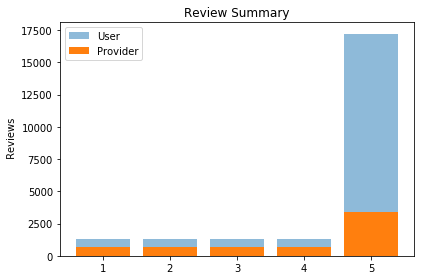

In [7]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
objects = df4.owner_review
index = np.arange(1,len(objects)+1)

rects1 =plt.bar(df4.owner_review,df4.owner_total , align='center', alpha=0.5,label='User')
rects2 =plt.bar(df5.provider_review,df5.provider_total , align='center', alpha=1,label='Provider')
plt.xticks(index, objects)
plt.ylabel(' Reviews')
plt.title('Review Summary')

plt.legend()
plt.tight_layout()
plt.show()

##  Assumption:
Owners are more likely to leave a review and tend to give a better review. Since Owner and Provider are two independent different persons, we assume whether they leave a review or tend to give a better review all depend on themself. For owners, assume the probability that they likely to leave a review is Pa. And the probability of the providers liley to leave a review a Pb. Clearly, both user and provider leave a review or not follow a Bernoulli distribution. Therefore, Pa-Pb follows a normal distribution.
 
 H0: ud = Pa-Pb=0;  Ha:ud = Pa-Pb>0;
        

In [8]:
#normal test
import math
import scipy.stats as st
pa_hat=df2['owner_review'].sum()/df2['owner_review'].count();
print(pa_hat)
pb_hat=df2['provider_review'].sum()/df2['provider_review'].count();  
print(pb_hat)                                       
p_hat=(df2['owner_review'].sum() + df2['provider_review'].sum())/(2*df2['owner_review'].count())
print(p_hat)
Se=math.sqrt(p_hat*(1-p_hat)*(2/df2['owner_review'].count()))
z=(pa_hat-pb_hat)/Se
print('P(Z<abs(z)):',st.norm.cdf(abs(z)))
pval = round((1 -st.norm.cdf(abs(z))),2)
print('P-value:',pval)
critical=st.norm.ppf(.95)
print('zvalue: ',z,'    ', 'critical value: ', critical) 

0.747648954906
0.20144219586
0.474545575383
P(Z<abs(z)): 1.0
P-value: 0.0
zvalue:  134.173986615      critical value:  1.64485362695


Our statistical test results also told us that p value is less than 0.05 and critical value great than 1.64. Thus, we have enough evidence rejecting the null hypothesis. Therefore, the owner is more likely to leave a review.
Next to test which tends to leave a better review. To test this, we consider stars as a continues variable. For the follwing query that the average reviews from the owner is 3.3 (Ua) and the average reviews from the providers is 0.78(Ub). It strongs our believe that owners tend to give a better review. This time use t statistics to test who tends to give a better review.
H0: Ua-Ub=0 Ha: Ua-Ub>0

In [9]:
query = '''
   select c.id,s.reviewer_id,c.requester_id,stars,sum((case when s.reviewer_id =c.requester_id then stars else 0 end)) as owner_review,Sum((case when s.reviewer_id !=c.requester_id then stars else 0 end)) as provider_review from
   (select id, requester_id from conversations_conversation  where booked_at!='NULL' and cancelled_at is NULL) c
   left join 
   conversations_review s on s.conversation_id =c.id
   group by c.id
'''
df3 = pd.read_sql_query(query, conn)
#Welch's t-test
pa_hat=df3['owner_review'].sum()/df3['owner_review'].count();
print('Average of Reviews from the owner:',pa_hat)
pb_hat=df3['provider_review'].sum()/df3['provider_review'].count();  
print('Average of Reviews from the Provider:',pb_hat) 
from scipy.stats import ttest_ind, ttest_ind_from_stats
import numpy as np
t, p = ttest_ind(df3['owner_review'], df3['provider_review'], equal_var=False)
print("ttest_ind: t = %g  p = %f" % (t,p/2))

Average of Reviews from the owner: 3.3014986874
Average of Reviews from the Provider: 0.786594889177
ttest_ind: t = 158.175  p = 0.000000


Average of Reviews from the owner: 3.3014986874
Average of Reviews from the Provider: 0.786594889177
    p value is less than 0.05, we have enough evidence rejecting the null hypothesis. Therefore, the owners tend to leave better reviews. 

It indicates that there is a great potiential that we will attract more users using our products resulting in great profit.

# Section III: Recent Daily Booking Rate

In the part, they gave me a snapshot of a database which was taken on 2018-08-02 at midnight and only contains data reflecting events prior to that date. They tell me that daily booking rate is defined to be the percentage of conversations created each day that eventually book and asked me what is the daily booking rate for each of the 90 days prior to the snapshot? They also concerned about an apparent downward trend and asked me to help them out.
              
The following query is calculating the daily booking rate prior to 2018-08-02 and the figure will give me a visualization how the daily booking rate changes over time.

In [10]:
# This query is calculating the daily booking rate prior to 2018-08-02 


query = '''
  select date(added) as addedday,sum((case when added is NULL then 0 else 1 end)) as addedNum,
  sum((case when booked_at is NULL then 0 else 1 end)) as booked,
  round(sum((case when booked_at is NULL then 0 else 1 end))/sum((case when added is NULL then 0.00 else 1.00 end)),2) as booked_rate from conversations_conversation
  group by addedday
'''
df1 = pd.read_sql_query(query, conn)
df1.isnull().sum()
#df1['addedday'].isnull
df1.sort_values('addedday')
df1.mean()
df1.head()

,addedday,addedNum,booked,booked_rate
0,2016-08-10,2,1,0.50
1,2016-08-11,4,2,0.50
2,2016-08-12,1,0,0.00
3,2016-08-13,1,1,1.00
4,2016-08-14,4,1,0.25


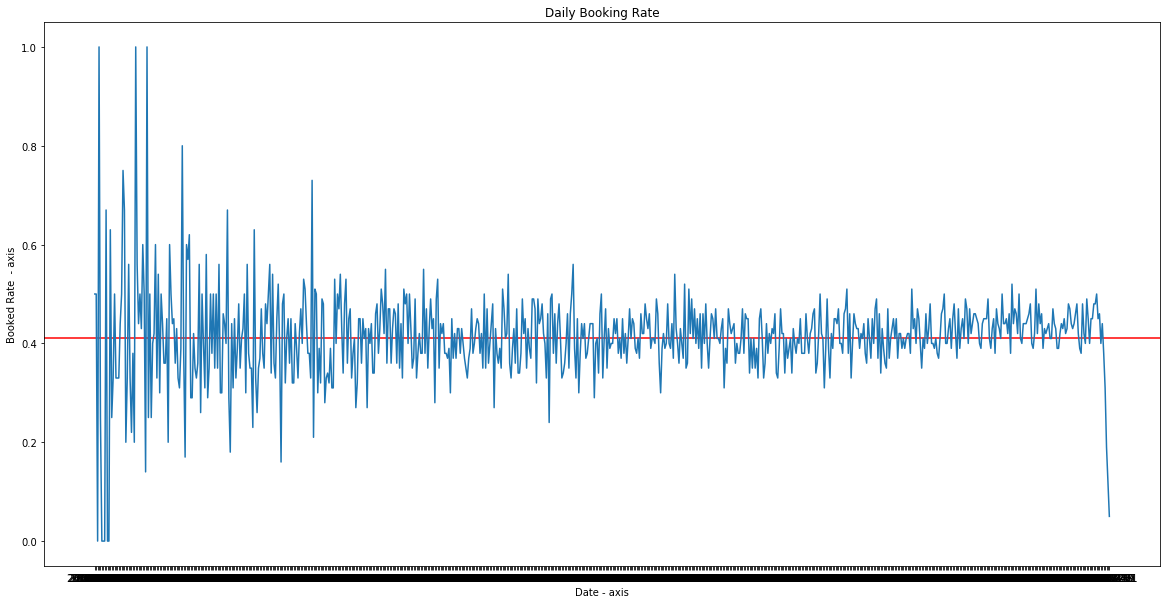

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(df1['addedday'], df1['booked_rate']) 
plt.axhline(0.41, color='r', zorder=-1)
# naming the x axis 
plt.xlabel('Date - axis') 
# naming the y axis 
plt.ylabel('Booked Rate  - axis') 
plt.title('Daily Booking Rate')   
# function to show the plot 
plt.show()

The following one is calculating what is the daily booking rate for each of the 90 days prior to the snapshot and the corresponding figure. 

In [12]:
query = '''
  select date(added) as addedday,sum((case when added is NULL then 0 else 1 end)) as addedNum,
  sum((case when booked_at is NULL then 0 else 1 end)) as booked,
  round(sum((case when booked_at is NULL then 0 else 1 end))/sum((case when added is NULL then 0.00 else 1.00 end)),2) as booked_rate,
  AVG(JulianDay(booked_at)-JulianDay( added)) as MeanDuration
  from conversations_conversation
  group by addedday
'''
df2 = pd.read_sql_query(query, conn)
#df1['addedday'].isnull
res = (df2.groupby(pd.PeriodIndex(df2.addedday, freq='Q'), axis=0).mean())
res


,addedNum,booked,booked_rate,MeanDuration
addedday,,,,
2016Q3,5.880000,2.460000,0.405200,3.420027
2016Q4,20.260870,8.206522,0.407717,3.169389
2017Q1,43.044444,17.944444,0.416000,3.216854
2017Q2,71.131868,28.956044,0.409011,3.204683
2017Q3,103.554348,42.847826,0.413587,3.191718
2017Q4,140.293478,57.195652,0.408804,3.146666
2018Q1,176.500000,73.522222,0.416667,3.169105
2018Q2,224.472527,97.758242,0.435604,3.203998
2018Q3,279.031250,113.156250,0.407500,2.950622


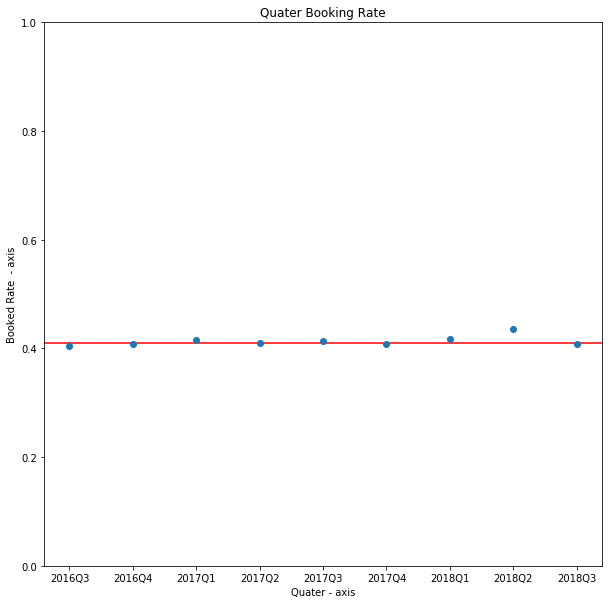

In [13]:
plt.figure(figsize=(10,10))
index=['2016Q3','2016Q4','2017Q1','2017Q2','2017Q3','2017Q4','2018Q1','2018Q2','2018Q3']
plt.scatter(index, res['booked_rate']) 
plt.axhline(0.41, color='r', zorder=-1)
# naming the x axis 
plt.xlabel('Quater - axis') 
# naming the y axis 
plt.ylabel('Booked Rate  - axis') 
plt.ylim(0, 1) 
plt.title('Quater Booking Rate')   
# function to show the plot 
plt.show()

From above two tables and figures, it looks like everything is on track and stable. I did not see a downward trend at all. What are their concerned about an apparent downward trend? Then I ploted the last two weeks' Daily Booking Rate and figured out their concerns. I can see that the average rate deceases so quickly. Warning!!!!!


However, after being training over 8 years in data science, I know that this might not be interpret as a "downward" since it only happens in these two weeks before the snapshot which was 2018-08-02. Then I calculate the average duration time from the conversations were created to eventually booked and noticed that the average duration time f is 3.189835 days, maximum duration time is 9.23591 day. It makes more sense now. There are some books are not reflecting in this database yet since the delayed reaction time. That's why as the day gets closer to 08-02-2018, the daily rate drops more. It might be needed to wait for another 1-2 weeks to get real market data.

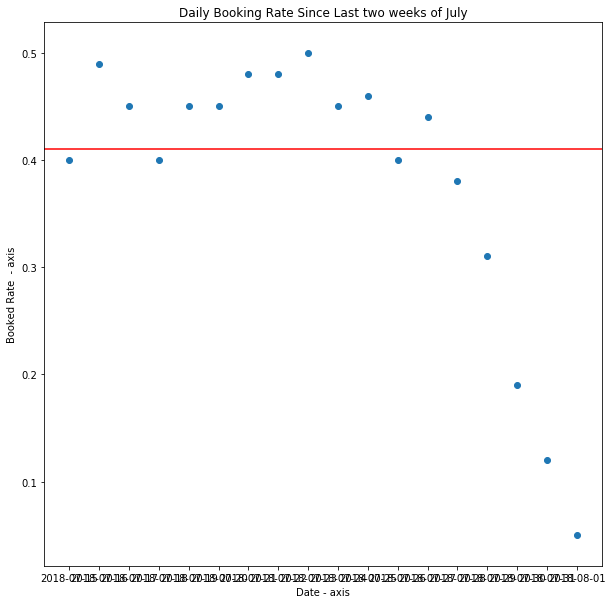

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(df1.iloc[702:720,0], df1.iloc[702:720,3]) 
plt.axhline(0.41, color='r', zorder=-1)
# naming the x axis 
plt.xlabel('Date - axis') 
# naming the y axis 
plt.ylabel('Booked Rate  - axis') 
plt.title('Daily Booking Rate Since Last two weeks of July')   
# function to show the plot 
plt.show()

In [15]:
df2.sort_values('addedday')
print('Mean of variables')
print(df2.mean());
print('_________________________')
print('Max of variables')
print(df2.max());
print('_________________________')
print('Min of variables')
print(df2.min());

Mean of variables
addedNum        111.361111
booked           46.480556
booked_rate       0.414264
MeanDuration      3.189835
dtype: float64
_________________________
Max of variables
addedday        2018-08-01
addedNum               310
booked                 140
booked_rate              1
MeanDuration       9.23591
dtype: object
_________________________
Min of variables
addedday        2016-08-10
addedNum                 1
booked                   0
booked_rate              0
MeanDuration      0.597971
dtype: object


# Section IV: New Conversation Flow

This part is the part I am the most interested in since it is my first time heard about A/B test. It takes me one day to take a class on Udemy to figure it out that nothing is new just a new name. Here is the details.
This platform had a conversation page where owners and service providers could exchange messages as they organized their booking. The team thought this page could use a re-design and set out to improve its UI. A product manager then set up a test to measure the new page's effectiveness. On 2018-04-04 , an A/B test was launched. For those owners who sent a request, they would be randomly assigned to variant or holdout groups. Those users who are in the variant group would see the new conversation flow. However, those in the holdout group would see the old conversation flow. Providers would always see the old conversation flow.

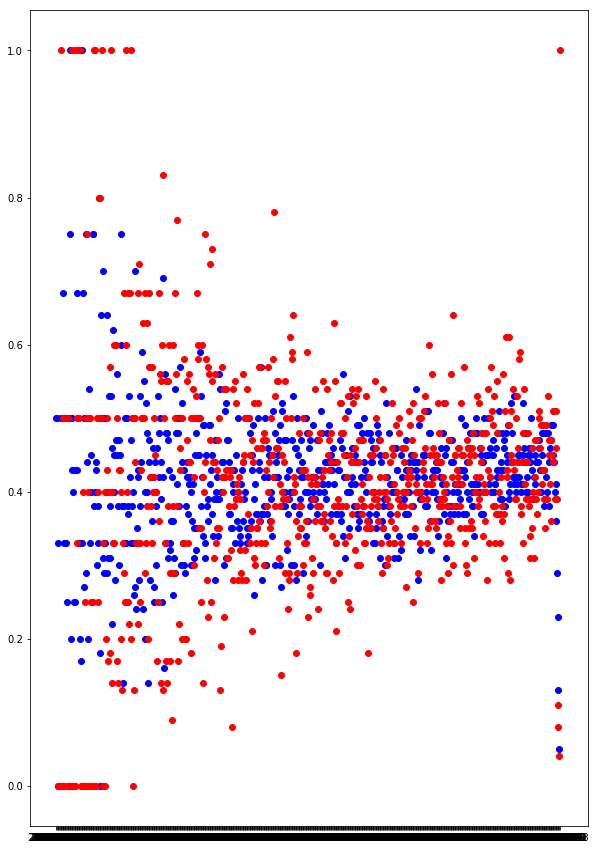

In [16]:
# This query to retrieve the data I need for A/B test

query = '''
select added,test_group, sum((case when added is NULL then 0 else 1 end)) as addedN,
sum((case when booked_at is NULL then 0 else 1 end)) as booked,
round(sum((case when booked_at is NULL then 0 else 1 end))/sum((case when added is NULL then 0.00 else 1.00 end)),2) as booked_rate
  
from

  (select date(C.added) as added,C.booked_at, p.test_group from conversations_conversation C
  left join
  people_testsegmentation P
  on
  p.id=C.requester_id ) A

group by added,test_group

'''
df = pd.read_sql_query(query, conn)


# This figure will give me a basic idea whether there exist a significant differnce in daily booking rate between two groups

tableA=df.loc[df['test_group']=='holdout']
tableB=df.loc[df['test_group']=='variant']

import matplotlib.pyplot as plt
plt.figure(figsize=(10,15))
plt.scatter(tableA['added'],tableA['booked_rate'],color='blue') 
plt.scatter(tableB['added'],tableB['booked_rate'],color='red') 
# naming the x axis 
#plt.xlabel('Date - axis') 
# naming the y axis 
#plt.ylabel('Booked Rate  - axis') 
#plt.title('Daily Booking Rate Since Last two weeks of July')   
# function to show the plot 
plt.show()

A little bit messy! But clealy there is no obvious difference between two groups except the reds' variance is slighly bigger. Let's group the data by month.

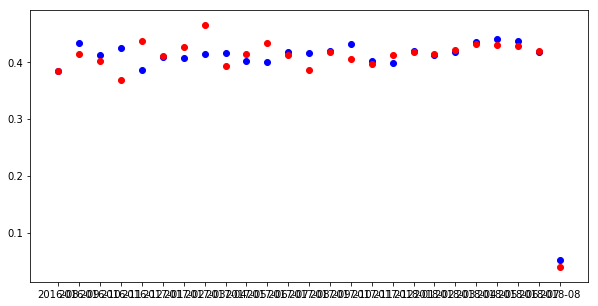

In [17]:
query = '''
select added,test_group, sum((case when added is NULL then 0 else 1 end)) as addedN,
sum((case when booked_at is NULL then 0 else 1 end)) as booked

from

  (select date(C.added) as added,C.booked_at, p.test_group from conversations_conversation C
  left join
  people_testsegmentation P
  on
  p.id=C.requester_id ) A

group by added,test_group

'''
df1 = pd.read_sql_query(query, conn)

res = (df1.groupby([pd.PeriodIndex(df1.added, freq='m'),'test_group'],axis=0).sum())

groupA=res.unstack(level=1)

A=groupA['booked']['holdout']/groupA['addedN']['holdout']
B=groupA['booked']['variant']/groupA['addedN']['variant']

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
index=['2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01',
             '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07',
             '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01',
             '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
             '2018-08']
plt.scatter(index,A,color='blue') 
plt.scatter(index,B,color='red') 
# naming the x axis 
#plt.xlabel('Date - axis') 
# naming the y axis 
#plt.ylabel('Booked Rate  - axis') 
#plt.title('Daily Booking Rate Since Last two weeks of July')   
# function to show the plot 
plt.show()



Much better i visualizaiton, but still no obvious difference in daily booked_rate.
Let test it:

Assuming users who are in the variant group would see the new conversation flow will book in a probability of Pa and those in the holdout group would see the old conversation flow will book in a probability of Pb. We are expecting Pb>Pa.  

H0: Assumping Pa =Pb; Ha: Pb > Pa;

Under H0, Pa_hat, Pb_hat are normal distributed with mean Pa, Pb respectively, and variane
Pa(1-Pa)/n, Pb(1-Pb)/n respectively.

In [18]:
# retrieve the related data from the database
query = '''
select added,test_group, (case when added is NULL then 0 else 1 end) as addedN,
(case when booked_at is NULL then 0 else 1 end) as booked
from
  (select date(C.added) as added,C.booked_at, p.test_group from conversations_conversation C
  left join
  people_testsegmentation P
  on
  p.id=C.requester_id
  ) A

'''
df3 = pd.read_sql_query(query, conn)
A=df3[df3['test_group']=='holdout']
B=df3[df3['test_group']=='variant']



# Hypothesis test:
import math
import scipy.stats as st
Pa_hat=A['booked'].sum()/A['addedN'].count();
print('Pa_hat:',Pa_hat)
Pb_hat=B['booked'].sum()/B['addedN'].count(); 
print('Pb_hat: ',Pb_hat)                                       
p_hat=(A['booked'].sum() + B['booked'].sum())/(A['addedN'].count() + B['addedN'].count())
print('p_hat: ',p_hat)
Se=math.sqrt(p_hat*(1-p_hat)*(1/A['addedN'].count() + 1/B['addedN'].count()))
z=(-Pa_hat + Pb_hat)/Se
print('P(Z<abs(z)):',st.norm.cdf(abs(z)))
pval = round((1 -st.norm.cdf(abs(z))),2)
print('P-value:',pval)
critical=st.norm.ppf(.95)
print('zvalue: ',z,'    ', 'critical value: ', critical) 

Pa_hat: 0.417809593898
Pb_hat:  0.41614358572
p_hat:  0.417385881766
P(Z<abs(z)): 0.661515331122
P-value: 0.34
zvalue:  -0.416602284954      critical value:  1.64485362695


# conclusion: 

p-value is greater than 0.05 and zvalue is less than critial value, we don't have enough evidence to reject null hypothesis. That is, there is no difference in two groups. Therefore,conversations with the new conversation page no obvious improment in booked_rate.

However, this frequentist test only give us the idea that there is no obvious difference in two group. It did give you a degree of confidence in it. Let's try using Bayesian A/B test. 

I'll use a beta distribution for the priors and a Bernoulli distribution for the likelihood.

In [20]:
import pymc
from pymc import Beta, Bernoulli, MCMC, deterministic
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np

n1=A['addedN'].count()
n2=B['addedN'].count()
# data for test
obs_A = A['booked']
obs_B = B['booked']

#define prior:
prior_A = Beta('prior_A', alpha=8, beta=10);
prior_B = Beta('prior_B', alpha=8, beta=10);



# Now define the model
@pymc.deterministic
def delta(prior_A=prior_A, prior_B=prior_B):
        return prior_B - prior_A

# define likelihood
like_A = Bernoulli('like_A',p=prior_A, value=obs_A, observed=True)
like_B = Bernoulli('like_B',p=prior_B, value=obs_B, observed=True)

# defining a Monte Carlo Markov Chain model
mcmc = MCMC([prior_A, prior_B, like_A, like_B, delta])
# setting the size of the simulations to 50k particles
mcmc.sample(50000,10000)

# the resulting posterior distribution is stored in the trace variable
p_A_samples = mcmc.trace('prior_A')[:] # posterior of P_A
#p_A_samples = mcmc.trace('p_A')[:]
#lower_bound = np.percentile(p_A_samples, 5)
#upper_bound = np.percentile(p_A_samples, 95)
#print 'There is 90%% probability that p_A is between %s and %s' %
#(lower_bound, upper_bound)
# There is 90% probability that p_A is between  and

p_B_samples = mcmc.trace('prior_B')[:]# posterior of P_B
delta_samples = mcmc.trace('delta')[:] # posterior of delta

 [-----------------100%-----------------] 50000 of 50000 complete in 56.8 sec

Plotting prior_A
Plotting delta
Plotting prior_B


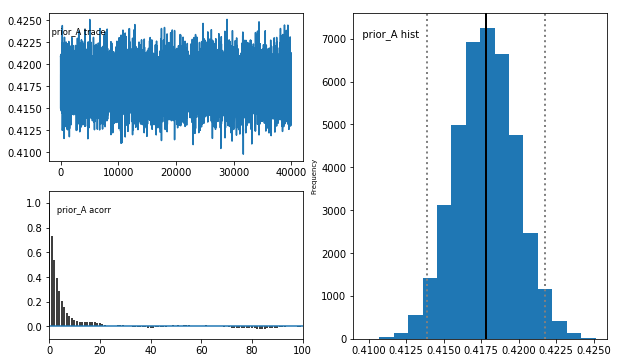

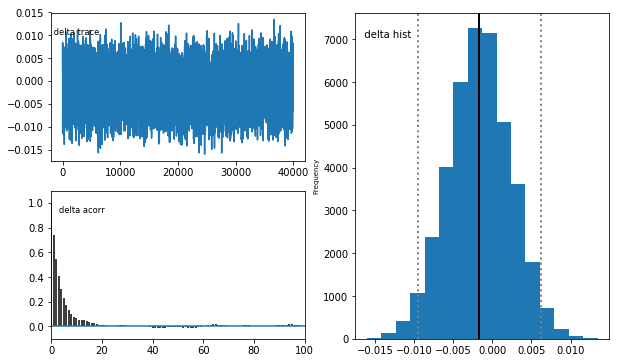

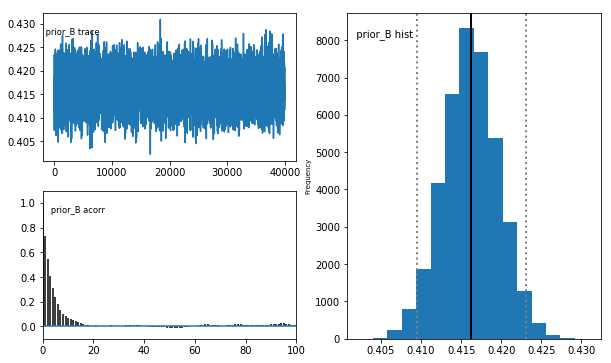

In [22]:
pymc.Matplot.plot(mcmc)


In [25]:
prior_A.summary()
prior_B.summary()



prior_A:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.418            0.002            0.0              [ 0.414  0.422]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.414            0.416           0.418          0.419         0.422
	

prior_B:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.416            0.003            0.0              [ 0.409  0.423]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.409            0.414           0.416          0.418         0.423
	


Above give us the posterior distribution of P_A. It means that the simulatation tell us 
that the P_A has a mean value 0.418 and 95% sure that this mean value will be in the interval [0.414, 0.422] given current observation data.

Above give us the posterior distribution of P_B. It means that the simulatation tell us 
that the P_A has a mean value 0.416 and 95% sure that this mean value will be in the interval [0.409, 0.423] given current observation data.

In [26]:
delta.summary()


delta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.002           0.004            0.0              [-0.009  0.006]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.01            -0.004          -0.002         0.001         0.006
	


I’ve created a delta function to create the posterior distribution for the difference of the two distributions. This simulatation tell us that the P_A - P_B has a mean value -0.002 and 95% confidence that this mean value will be in the interval [-0.009, 0.007] given current observation data. We can also answer that the probabily the new conversation flow is better than the old one is 34.16%.

In [27]:
print('Probability that p_B > p_A:')
print ((delta_samples > 0).mean())
print('Probability that p_B < p_A:')
print ((delta_samples < 0).mean())

Probability that p_B > p_A:
0.34155
Probability that p_B < p_A:
0.65845


In [28]:
conn.close()